<a href="https://colab.research.google.com/github/RAMANABORA/currency-converter/blob/main/Innomatics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Initialization

In [ ]:
import pandas as pd
import json
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Data Loading

In [ ]:
orders_df = pd.read_csv('orders.csv')

In [ ]:
with open('users.json', 'r') as f:
    users_data = json.load(f)
users_df = pd.DataFrame(users_data)

In [ ]:
# Create a temporary database in memory
conn = sqlite3.connect(':memory:')
with open('restaurants.sql', 'r') as f:
    sql_script = f.read()
conn.executescript(sql_script)

# Read the table into a DataFrame
restaurants_df = pd.read_sql_query("SELECT * FROM restaurants", conn)

The Master Merge

In [ ]:
# Merge Orders with Users
merged_df = pd.merge(orders_df, users_df, on='user_id', how='left')

# Merge with Restaurants
final_df = pd.merge(merged_df, restaurants_df, on='restaurant_id', how='left')

# Cleanup: Rename columns to avoid confusion
final_df = final_df.rename(columns={
    'restaurant_name_x': 'order_restaurant_name',
    'restaurant_name_y': 'master_restaurant_name'
})

# Export the clean file
final_df.to_csv('final_food_delivery_dataset.csv', index=False)
print("Final Dataset Ready!")

Final Dataset Ready!


1. City Revenue (Gold Members):

In [ ]:
gold_city_rev = final_df[final_df['membership'] == 'Gold'].groupby('city')['total_amount'].sum()
print(gold_city_rev.sort_values(ascending=False))

city
Chennai      1080909.79
Pune         1003012.32
Bangalore     994702.59
Hyderabad     896740.19
Name: total_amount, dtype: float64


2. Cuisine Avg Order Value:

In [ ]:
cuisine_avg = final_df.groupby('cuisine')['total_amount'].mean()
print(cuisine_avg.sort_values(ascending=False))

cuisine
Mexican    808.021344
Italian    799.448578
Indian     798.466011
Chinese    798.389020
Name: total_amount, dtype: float64


3. Distinct Users with Total Spend > 1000:

In [ ]:
user_total = final_df.groupby('user_id')['total_amount'].sum()
print(f"Users > 1000: {(user_total > 1000).sum()}")

Users > 1000: 2544


4. Quarterly Revenue:

In [ ]:
final_df['order_date'] = pd.to_datetime(final_df['order_date'], format='%d-%m-%Y')
print(final_df.groupby(final_df['order_date'].dt.quarter)['total_amount'].sum())

order_date
1    2010626.64
2    1945348.72
3    2037385.10
4    2018263.66
Name: total_amount, dtype: float64


A. Customer & City Insights

In [ ]:
# Q: Distinct users and Gold member count
print(f"Total Unique Users: {final_df['user_id'].nunique()}")
print(f"Total Gold Member Orders: {len(final_df[final_df['membership'] == 'Gold'])}")

# Q: Top Revenue City for Gold Members
gold_city_stats = final_df[final_df['membership'] == 'Gold'].groupby('city').agg(
    total_revenue=('total_amount', 'sum'),
    order_count=('total_amount', 'count')
).sort_values(by='total_revenue', ascending=False)

print("\nGold Membership City Performance:")
print(gold_city_stats)

Total Unique Users: 2883
Total Gold Member Orders: 4987

Gold Membership City Performance:
           total_revenue  order_count
city                                 
Chennai       1080909.79         1337
Pune          1003012.32         1284
Bangalore      994702.59         1254
Hyderabad      896740.19         1112


B. Restaurant & Cuisine Performance

In [ ]:
# Q: High rated orders and Cuisine AOV
print(f"Orders with Rating >= 4.5: {len(final_df[final_df['rating'] >= 4.5])}")

cuisine_stats = final_df.groupby('cuisine')['total_amount'].mean().sort_values(ascending=False)
print("\nAverage Order Value by Cuisine:")
print(cuisine_stats)

Orders with Rating >= 4.5: 3374

Average Order Value by Cuisine:
cuisine
Mexican    808.021344
Italian    799.448578
Indian     798.466011
Chinese    798.389020
Name: total_amount, dtype: float64


C. Revenue Trends

In [ ]:
# Q: Quarterly Revenue
final_df['quarter'] = final_df['order_date'].dt.quarter
quarterly_rev = final_df.groupby('quarter')['total_amount'].sum()
print("\nQuarterly Revenue Breakdown:")
print(quarterly_rev)

# Q: Highest Revenue Combination
combo_rev = final_df.groupby(['membership', 'cuisine'])['total_amount'].sum().idxmax()
print(f"\nHighest Revenue Combination: {combo_rev}")


Quarterly Revenue Breakdown:
quarter
1    2010626.64
2    1945348.72
3    2037385.10
4    2018263.66
Name: total_amount, dtype: float64

Highest Revenue Combination: ('Regular', 'Mexican')


4. Professional Visualizations

/tmp/ipython-input-687972483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quarterly_rev.index, y=quarterly_rev.values, palette='viridis')


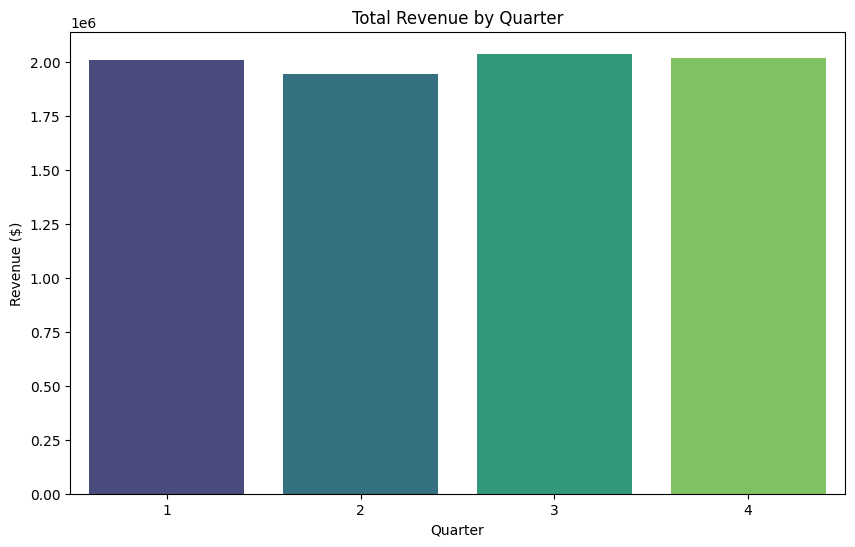

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=quarterly_rev.index, y=quarterly_rev.values, palette='viridis')
plt.title('Total Revenue by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Revenue ($)')
plt.show()